# Lyrics sentiment analysis and prediction using pyspark



This notebook file reads 2 CSV files, one with Songs lyricss and other with Songs classified by sentiments


In [ ]:
!gdown 17Sc5B6-946GusvQB6O8nLXmFrnBbQ1Xg -O /content/sample_data/completes.csv
#https://drive.google.com/file/d/17Sc5B6-946GusvQB6O8nLXmFrnBbQ1Xg/view?usp=sharing


Downloading...
From: https://drive.google.com/uc?id=17Sc5B6-946GusvQB6O8nLXmFrnBbQ1Xg
To: /content/sample_data/completes.csv
100% 35.7M/35.7M [00:00<00:00, 105MB/s]


## Adding dependencies

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=8eefe2528f75ad7e93cbbb0a28ed03d2290d7ea2dfd0d4d11f5920ed92f69796
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
import math
import pandas as pd
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql import SQLContext
from IPython import display
from pyspark.sql import SQLContext
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import SparkSession

## Creating Spark context

In [ ]:
spark = SparkSession.builder \
        .master("local[*]") \
        .appName("test") \
        .config("spark.driver.memory", "5g")\
        .config("spark.executor.memory", "5g")\
        .config("spark.memory.offHeap.enabled", True)\
        .config("spark.memory.offHeap.size","2g")\
        .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

spark.sparkContext._conf.getAll()  # check the config

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'),
 ('spark.app.name', 'test'),
 ('spark.app.startTime', '1714408465633'),
 ('spark.driver.port', '40699')

## Creating Schema for Emotions file

In [ ]:
shcemaOutput = StructType([
    StructField("artist", StringType()),
    StructField("title", StringType()),
    StructField("seeds", StringType()),
    StructField("number_of_emotion_tags", StringType()),
    StructField("valence_tags", StringType()),
    StructField("arousal_tags", StringType()),
    StructField("dominance_tags", StringType()),
    StructField("genre", StringType()),
    StructField("year", StringType()),
    StructField("lyrics", StringType())
])

## Definition of files

In [ ]:
#song_lyrics.csv file contains 3093218 songs data
outputFile = '/content/sample_data/completes.csv'

Reading CSV files for Emotions and Lyrics

In [ ]:
innerJoin = sqlContext.read.format("csv").option("ignoreLeadingWhiteSpace", "true").option("multiline", "true").option('quote','"').option('escape', '"').option("header", "true").schema(shcemaOutput).load(outputFile)#.limit(10000)

## Preparing Data and new columns

In [ ]:
innerJoin.show(truncate = 10)
innerJoin.count()

+----------+----------+----------+----------------------+------------+------------+--------------+----------+----+----------+
|    artist|     title|     seeds|number_of_emotion_tags|valence_tags|arousal_tags|dominance_tags|     genre|year|    lyrics|
+----------+----------+----------+----------------------+------------+------------+--------------+----------+----+----------+
|   Afroman|      Hush|['posit...|                     1|        7.57|         5.5|          7.26|   hip-hop|2000|[Hook] ...|
|Aimee Mann|    You Do|['smooth']|                    15|  5.51230...|  3.25753...|    5.47857...|singer-...|1999|[Verse ...|
|Air Supply|Even th...|['roman...|                     4|  7.42000...|      4.9625|    5.91166...| soft rock|1982|I, I wa...|
|Alice C...|      DaDa|['spooky']|                     1|         4.4|         6.0|          4.48|classic...|1983|Da Da\n...|
|Alicia ...|     Diary|['smooth']|                    14|  6.61333...|  3.94787...|    5.95272...|      soul|2004|[Ver

27349

In [ ]:
innerJoin = innerJoin.withColumn("valence_tags", \
                     F.when(innerJoin.valence_tags.between(0, 4), 0)\
                     #.otherwise(F.when(innerJoin.valence_tags.between(2, 4), 1)\
                     #  .otherwise(F.when(innerJoin.valence_tags.between(4, 6), 2)\
                         .otherwise(F.when(innerJoin.valence_tags > 4, 1)))

In [ ]:
innerJoin = innerJoin.withColumn("arousal_tags", \
                     F.when(innerJoin.arousal_tags.between(0, 4), 0)\
                     #.otherwise(F.when(innerJoin.arousal_tags.between(2, 4), 1)\
                     #  .otherwise(F.when(innerJoin.arousal_tags.between(4, 6), 2)\
                         .otherwise(F.when(innerJoin.arousal_tags  > 4, 1)))

In [ ]:
innerJoin = innerJoin.withColumn("dominance_tags", \
                     F.when(innerJoin.dominance_tags.between(0, 2), 0)\
                     .otherwise(F.when(innerJoin.dominance_tags.between(2, 4), 1)\
                       .otherwise(F.when(innerJoin.dominance_tags.between(4, 6), 2)\
                         .otherwise(F.when(innerJoin.dominance_tags  > 6, 3)))))

In [ ]:
categories = {'00':'Happy', '10':'Angry', '01':'Relaxed', '11':'Sad'}

innerJoin = innerJoin.withColumn('category', F.concat(F.col("valence_tags"), F.col('arousal_tags')))
innerJoin = innerJoin.replace(to_replace=categories, subset=['category'])

In [ ]:
innerJoin.show(truncate = 10)

+----------+----------+----------+----------------------+------------+------------+--------------+----------+----+----------+---------+
|    artist|     title|     seeds|number_of_emotion_tags|valence_tags|arousal_tags|dominance_tags|     genre|year|    lyrics| category|
+----------+----------+----------+----------------------+------------+------------+--------------+----------+----+----------+---------+
|   Afroman|      Hush|['posit...|                     1|           1|           1|             3|   hip-hop|2000|[Hook] ...| Sluggish|
|Aimee Mann|    You Do|['smooth']|                    15|           1|           0|             2|singer-...|1999|[Verse ...|      Sad|
|Air Supply|Even th...|['roman...|                     4|           1|           0|             2| soft rock|1982|I, I wa...|      Sad|
|Alice C...|      DaDa|['spooky']|                     1|           0|           1|             1|classic...|1983|Da Da\n...|    Bored|
|Alicia ...|     Diary|['smooth']|              

In [ ]:
from pyspark.sql.functions import col
innerJoin.groupBy("artist").count().orderBy(col("count").desc()).show()
innerJoin.groupBy("category").count().orderBy(col("count").desc()).show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|           Bob Dylan|   82|
|        Warren Zevon|   76|
|They Might Be Giants|   74|
|     Robbie Williams|   73|
|            The Cure|   73|
|           Radiohead|   67|
|         The Beatles|   67|
|Manic Street Prea...|   63|
|       Chelsea Wolfe|   59|
|  The Mountain Goats|   59|
|         of Montreal|   58|
|           Kate Bush|   55|
|           Tori Amos|   54|
|       Elliott Smith|   53|
|    Barenaked Ladies|   53|
|         Bright Eyes|   52|
|   Animal Collective|   51|
|         Yo La Tengo|   51|
|      Regina Spektor|   50|
|       Kylie Minogue|   49|
+--------------------+-----+
only showing top 20 rows

+---------+-----+
| category|count|
+---------+-----+
|      Sad|12650|
|Depressed| 7065|
| Sluggish| 5834|
|    Bored| 1800|
+---------+-----+



## Model Pipeline

Spark Machine Learning Pipelines API is similar to Scikit-Learn. Our pipeline includes three steps:

regexTokenizer: Tokenization (with Regular Expression)

stopwordsRemover: Remove Stop Words

countVectors: Count vectors (“document-term vectors”)

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression

# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="lyrics", outputCol="words", pattern="[^a-zA-Z]")

# stop words
add_stopwords = []
add_stopwords.extend(stopwords.words('english'))
add_stopwords.extend(["verse","intro","chorus","rt","t","c","m","s","da","the"])

stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=5000, minDF=100)

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

label_stringIdx = StringIndexer(inputCol = "category", outputCol = "label")
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(innerJoin)
dataset = pipelineFit.transform(innerJoin)

In [ ]:
#dataset.select("words", "filtered", "features", "label").orderBy(col("label").asc()).show(truncate=30)
dataset.select("filtered").orderBy(col("label").asc()).show(100, truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                            filtered|
+----------------------------------------------------------------------------------------------------+
|[mind, believe, maybe, forgive, rather, simply, run, getting, closer, time, cause, one, every, be...|
|[everything, must, end, every, romance, must, descend, every, lover, pact, decays, every, sad, mi...|
|[like, could, die, broken, heart, one, smile, could, fix, get, back, fall, believed, songs, sang,...|
|[lonely, one, wondering, went, wrong, love, gone, left, lonely, confused, feeling, like, used, ca...|
|[maybe, moonbeam, light, way, evening, comes, worry, care, bout, cold, outside, glad, wish, magic...|
|[told, could, give, life, would, leave, boundaries, mind, bet, never, even, knew, universe, insid...|
|[embody, spirit, motion, bodies, motion, bodies, motion, dig, ocean, swi

In [ ]:
dataset.groupBy("label").count().orderBy(col("count").desc()).show()
dataset.count()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|12650|
|  1.0| 7065|
|  2.0| 5834|
|  3.0| 1800|
+-----+-----+



27349

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

window = Window.partitionBy(dataset['label']).orderBy(F.rand())
dataset = dataset.select(F.col('*'),
               F.row_number().over(window).alias('row_number')) \
               .where(F.col('row_number') <= 8000)

In [ ]:
dataset.groupBy("label").count().orderBy(col("count").desc()).show()
dataset.count()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 8000|
|  1.0| 7065|
|  2.0| 5834|
|  3.0| 1800|
+-----+-----+



22699

## Partition Training & Test sets

In [ ]:
# set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.8, 0.2])
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 18202
Test Dataset Count: 4497


## Model Training and Evaluation

Logistic Regression using Count Vector Features

Our model will make predictions and score on the test set; we then look at the top 10 predictions from the highest probability.

In [ ]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0).select("filtered", "category","probability","label","prediction")\
.orderBy("probability", ascending=False).show(n = 10, truncate = 30)

+------------------------------+---------+------------------------------+-----+----------+
|                      filtered| category|                   probability|label|prediction|
+------------------------------+---------+------------------------------+-----+----------+
|[yo, landi, rich, bitch, yo...|    Bored|[0.9780292501517323,0.00344...|  3.0|       0.0|
|[never, see, wanted, love, ...|Depressed|[0.9461346209007581,0.02659...|  1.0|       0.0|
|[got, back, long, flight, s...| Sluggish|[0.8913257814764817,0.05780...|  2.0|       0.0|
|[sometimes, forget, believe...|Depressed|[0.8712807684034769,0.05773...|  1.0|       0.0|
|[got, big, balls, big, ol, ...| Sluggish|[0.8588379990340875,0.08545...|  2.0|       0.0|
|[moment, chance, buried, bl...|    Bored|[0.8531922706541692,0.03695...|  3.0|       0.0|
|[soldier, army, lord, soldi...|Depressed|[0.847107238385951,0.063672...|  1.0|       0.0|
|[running, best, three, gunn...| Sluggish|[0.8438253945350035,0.01752...|  2.0|       0.0|

In [ ]:
predictions.filter(predictions['prediction'] == 1).select("filtered", "category","probability","label","prediction")\
.orderBy("probability", ascending=False).show(n = 10, truncate = 30)

+------------------------------+---------+------------------------------+-----+----------+
|                      filtered| category|                   probability|label|prediction|
+------------------------------+---------+------------------------------+-----+----------+
|[saw, kiss, sweet, william,...|      Sad|[0.4356377621324464,0.44726...|  0.0|       1.0|
|[middle, summer, sleeping, ...|Depressed|[0.4271152442797836,0.48651...|  1.0|       1.0|
|[sure, find, true, love, an...|Depressed|[0.4202027091902446,0.43633...|  1.0|       1.0|
|[takes, early, train, butto...|      Sad|[0.4174578117608305,0.42093...|  0.0|       1.0|
|[ramblin, begin, taste, sum...|      Sad|[0.4168801478061441,0.45533...|  0.0|       1.0|
|[blood, turn, brown, dries,...| Sluggish|[0.41346859176579204,0.4171...|  2.0|       1.0|
|[loss, leader, losing, sigh...| Sluggish|[0.4132297758126317,0.42707...|  2.0|       1.0|
|[four, strong, winds, blow,...|Depressed|[0.40808586999583724,0.4549...|  1.0|       1.0|

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
lrAccuracy = evaluator.evaluate(predictions)
print(lrAccuracy)

0.37289507544193035


## ROC curve
https://spark.apache.org/docs/latest/ml-classification-regression.html#multinomial-logistic-regression

https://spark.apache.org/docs/2.3.0/api/java/org/apache/spark/ml/classification/LogisticRegressionTrainingSummary.html

In [ ]:
trainingSummary = lrModel.summary

# for multiclass, we can inspect metrics on a per-label basis
print("\nFalse positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nTrue positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("\nPrecision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("\nRecall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("\nF-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("\nAccuracy: %s\n\nFPR: %s\n\nTPR: %s\n\nF-measure: %s\n\nPrecision: %s\n\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))


False positive rate by label:
label 0: 0.3633585193989303
label 1: 0.24726546906187624
label 2: 0.07914572864321608
label 3: 0.0006559332140727489

True positive rate by label:
label 0: 0.7139965748092791
label 1: 0.5709001233045623
label 2: 0.38843683083511776
label 3: 0.0712290502793296

Precision by label:
label 0: 0.5172569366117753
label 1: 0.5113600504891133
label 2: 0.6287694974003466
label 3: 0.9026548672566371

Recall by label:
label 0: 0.7139965748092791
label 1: 0.5709001233045623
label 2: 0.38843683083511776
label 3: 0.0712290502793296

F-measure by label:
label 0: 0.5999084308980311
label 1: 0.5394923012900541
label 2: 0.4802117802779616
label 3: 0.1320388349514563

Accuracy: 0.5352708493572135

FPR: 0.2256964996753089

TPR: 0.5352708493572136

F-measure: 0.513546768027154

Precision: 0.5743482932235607

Recall: 0.5352708493572136


## Logistic Regression using TF-IDF Features

In [ ]:
from pyspark.ml.feature import HashingTF, IDF

hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=3000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF, idf, label_stringIdx])

pipelineFit = pipeline.fit(innerJoin)
dataset = pipelineFit.transform(innerJoin)

(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0) \
    .select("category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+---------+------------------------------+-----+----------+
| category|                   probability|label|prediction|
+---------+------------------------------+-----+----------+
|      Sad|[0.9999999324239114,1.63463...|  0.0|       0.0|
|    Bored|[0.9836629112177724,0.00202...|  3.0|       0.0|
|      Sad|[0.9702342613050158,0.00497...|  0.0|       0.0|
|Depressed|[0.9460180762755637,0.03676...|  1.0|       0.0|
|Depressed|[0.9381898734837107,0.01019...|  1.0|       0.0|
| Sluggish|[0.9363316141983217,0.03109...|  2.0|       0.0|
| Sluggish|[0.9356523603185324,0.02694...|  2.0|       0.0|
|      Sad|[0.9344038879965207,0.02503...|  0.0|       0.0|
|Depressed|[0.9090740540049982,0.07435...|  1.0|       0.0|
| Sluggish|[0.8996252490286942,0.06735...|  2.0|       0.0|
+---------+------------------------------+-----+----------+
only showing top 10 rows



In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.3929649948669445

## Cross-Validation
Let’s now try cross-validation to tune our hyper parameters, and we will only tune the count vectors Logistic Regression.

In [ ]:
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

pipelineFit = pipeline.fit(innerJoin)
dataset = pipelineFit.transform(innerJoin)
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
#            .addGrid(model.maxIter, [10, 20, 50]) #Number of iterations
#            .addGrid(idf.numFeatures, [10, 100, 1000]) # Number of features
             .build())

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)

cvModel = cv.fit(trainingData)

predictions = cvModel.transform(testData)
# Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)
#print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

0.4164905444567595

## Naive Bayes

In [ ]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1)
nbModel = nb.fit(trainingData)
predictions = nbModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("title","artist", "category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 50)

predictions.toPandas().to_csv('/content/sample_datanaiveBayes.csv', index=False)


+--------------------------------------------------+----------------------+---------+--------------------------------------------------+-----+----------+
|                                             title|                artist| category|                                       probability|label|prediction|
+--------------------------------------------------+----------------------+---------+--------------------------------------------------+-----+----------+
|                            Good Morning Starshine|Strawberry Alarm Clock|      Sad|[0.9999999999997777,2.1973168406692238E-13,2.39...|  0.0|       0.0|
|Objects in the Rear View Mirror May Appear Clos...|             Meat Loaf|Depressed|[0.9999999999981861,1.8137994679118725E-12,8.97...|  1.0|       0.0|
|                                    Walking on Air|            Katy Perry|      Sad|[0.9999999999969476,7.973620522011614E-15,3.044...|  0.0|       0.0|
|                                       Missing You|                  Case| 

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
nbAccuracy = evaluator.evaluate(predictions)
print(nbAccuracy)

0.43588967426469355


## DecisionTreeClassifier

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(trainingData)
predictions = dtModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("title","artist","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+----------------+----------------+---------+------------------------------+-----+----------+
|           title|          artist| category|                   probability|label|prediction|
+----------------+----------------+---------+------------------------------+-----+----------+
|  Amaze Disgrace|               3|      Sad|[0.4969512195121951,0.20846...|  0.0|       0.0|
|Abandon All Hope|      Aesop Rock|Depressed|[0.4969512195121951,0.20846...|  1.0|       0.0|
|    All Mixed Up|             311|      Sad|[0.4969512195121951,0.20846...|  0.0|       0.0|
|  Electric Twist|   A Fine Frenzy|      Sad|[0.4969512195121951,0.20846...|  0.0|       0.0|
|             Pet|A Perfect Circle|    Bored|[0.4969512195121951,0.20846...|  3.0|       0.0|
| Channel Swimmer|            10cc|      Sad|[0.4969512195121951,0.20846...|  0.0|       0.0|
|           Smile|             AFI|Depressed|[0.4969512195121951,0.20846...|  1.0|       0.0|
|   Double Vision|           3OH!3| Sluggish|[0.496951219512

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
dtAccuracy = evaluator.evaluate(predictions)
print(dtAccuracy)

0.33605372623859264


## Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)
# Train model with Training Data
rfModel = rf.fit(trainingData)
predictions = rfModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("filtered","category","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+---------+------------------------------+-----+----------+
|                      filtered| category|                   probability|label|prediction|
+------------------------------+---------+------------------------------+-----+----------+
|[yeah, yeah, ooh, ooh, ooh,...|      Sad|[0.4803841969781261,0.24236...|  0.0|       0.0|
|[go, away, summer, day, mig...|Depressed|[0.47840172520099605,0.2521...|  1.0|       0.0|
|[way, way, way, way, way, w...|      Sad|[0.47713147216145385,0.2568...|  0.0|       0.0|
|[times, walk, like, passing...|      Sad|[0.4767926551715307,0.26427...|  0.0|       0.0|
|[planned, understand, know,...|      Sad|[0.47669749552393414,0.2572...|  0.0|       0.0|
|[lately, wondering, take, p...|      Sad|[0.4763542038662735,0.23804...|  0.0|       0.0|
|[love, summer, gone, eyes, ...|      Sad|[0.47634312619071445,0.2612...|  0.0|       0.0|
|[leave, pain, leave, rain, ...|      Sad|[0.47582680901119323,0.2443...|  0.0|       0.0|

In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
rfAccuracy = evaluator.evaluate(predictions)
print(rfAccuracy)

0.30228073087273916


## OnevsRest classifer

In [ ]:
from pyspark.ml.classification import LogisticRegression, OneVsRest

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

ovr = OneVsRest(classifier=lr)

ovrModel = ovr.fit(trainingData)

# score the model on test data.
predictions = ovrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0) \
    .select("filtered","category","label","prediction") \
    .show(n = 10, truncate = 30)

+------------------------------+---------+-----+----------+
|                      filtered| category|label|prediction|
+------------------------------+---------+-----+----------+
|[think, help, wonder, yeste...|Depressed|  1.0|       0.0|
|[saw, came, evening, sighs,...|      Sad|  0.0|       0.0|
|[another, page, history, an...|      Sad|  0.0|       0.0|
|[remember, dessert, places,...|Depressed|  1.0|       0.0|
|[history, bluest, grace, fa...|      Sad|  0.0|       0.0|
|[digging, deeper, mind, get...|      Sad|  0.0|       0.0|
|[buck, drew, gustafson, aug...|Depressed|  1.0|       0.0|
|[well, cold, water, cold, s...|      Sad|  0.0|       0.0|
|[desert, landscape, continu...|    Bored|  3.0|       0.0|
|[devolving, backwards, glor...|Depressed|  1.0|       0.0|
+------------------------------+---------+-----+----------+
only showing top 10 rows



In [ ]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
ovrAccuracy = evaluator.evaluate(predictions)
print(ovrAccuracy)

0.3801809199123637


## Visualization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
model = ['Logistic regression', 'Naive Bayes', 'Random Forest', 'OneVsRest']
accuracy = [lrAccuracy,nbAccuracy,rfAccuracy, ovrAccuracy]

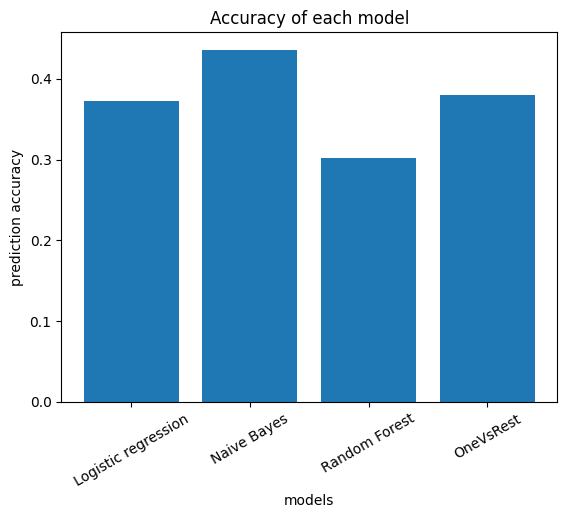

In [ ]:
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(model))
    plt.bar(index, accuracy)
    plt.xlabel('models', fontsize=10)
    plt.ylabel('prediction accuracy', fontsize=10)
    plt.xticks(index, model, fontsize=10, rotation=30)
    plt.title('Accuracy of each model')
    plt.show()

plot_bar_x()